IDEAT: KMEANS VIX, Cap max weight for factor

<div style="font-size:14px;">
<strong>TO DO:</strong><br><br>
Tarkistaa ovatko regiimit oikein, exp. antaa ainoana kaikille neg sharpet<br>
Katsoa vielä financial turbulence koodi<br>
Data varmistukset (ei dataa tulevaisuudesta)<br><br>

<strong>Lisää features:</strong><br>
RSI<br>
Yield spread<br>
Muita??<br><br>

<strong>Muuta:</strong><br>
regiimi testaus drawdowneilla?<br><br>
regiimi specifi model ennustus?


<strong>Mallin kehitys:</strong><br>
1. Feature eliminointi<br>
2. Training interval<br>
3. Hyperparametrit
</div>



# GIT & imports

In [259]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 135 (delta 64), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (135/135), 10.75 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Gradu
 chatti_RF.ipynb	       FT_source.xlsx  'RF REGIIMI HYVÄ TRAINING.ipynb'   THE_ONE.xlsx
'Financial turbulence.ipynb'   RF_Gradu.ipynb  'RF_regime (3).ipynb'


In [260]:
skip_training = False


In [261]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [262]:
# Load and flatten the data
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
df = xls_file.parse("returns non-log")
df.columns = df.columns.get_level_values(0)

print("Headers in the 'returns non-log' sheet:")
print(df.columns)

# Features to used as predictive variables
FEATURES = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Financial condition', 'Drawdown', '10y-2y']

# Model split by column
REGIMES_COLUMN = 'Vix-regimes2'

# Used factors
FACTORS = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]

BENCHMARK = [
    'USA Standard (Large+Mid Cap)'
]

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'returns non-log' sheet:
Index(['Date', 'USA Standard (Large+Mid Cap)',
       'USA MOMENTUM Standard (Large+Mid Cap)',
       'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
       'USA RISK WEIGHTED Standard (Large+Mid Cap)',
       'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
       'USA ENHANCED VALUE Standard (Large+Mid Cap)', 'Winning Factor',
       'VIXCLS', 'GDPC1', 'CPI', 'LEI', '10yr', 'Financial Turbulance',
       'H.Regimes', 'Financial condition', 'Drawdown', 'HY Spread',
       'IG Spread', '10y-2y', 'Vix-regimes2', 'Vix-regimes3'],
      dtype='object')


Description,Value
First observation date,1990-03-30 00:00:00
Last observation date,2024-10-31 00:00:00
Total number of observations,416


In [263]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,8.65%,14.89%,1673.42%
USA MOMENTUM Standard (Large+Mid Cap),12.00%,16.06%,4984.49%
USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),7.75%,11.71%,1229.41%
USA RISK WEIGHTED Standard (Large+Mid Cap),8.41%,13.77%,1542.37%
USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),10.09%,14.84%,2699.29%
USA ENHANCED VALUE Standard (Large+Mid Cap),8.15%,16.42%,1412.00%


In [264]:
# # Prepare Data for Model Training – Data Cleaning & Verification

# we keep all rows and compute the winning factor as the factor (from FACTORS) with the highest value in each row.

# Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# Check missing values in feature columns (FEATURES) before dropping NAs.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in feature columns before dropping NA:")
print(missing_counts)

# Save the number of rows before dropping NA and then drop rows with missing values in FEATURES.
initial_rows_features = len(df)
X = df[FEATURES].dropna()
rows_after_drop = len(X)
dropped_rows = initial_rows_features - rows_after_drop

if dropped_rows > 0:
    print(f"\nDropped {dropped_rows} rows due to missing values in feature columns.")
else:
    print("\nNo missing values found in feature columns. Data is clean.")

# Compute the Winning Factor by taking the column (from FACTORS) that has the maximum value in each row.
# This assumes that the FACTORS columns exist in df and contain numeric values.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1)

# Define the target variable based on rows retained in X.
# The winning factor is encoded as a categorical variable.
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]
print("\nIndices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date.
df = df.sort_values('Date').reset_index(drop=True)

# Verify that all required columns exist.
# Here, we require the FEATURES columns, the 'USA Standard (Large+Mid Cap)' column,
# as well as all the FACTORS and the BENCHMARK columns.
required_columns = FEATURES + FACTORS + BENCHMARK
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("\nParameters and dataset verified.")

# Compute the counts for each winning factor.
winning_factor_counts = df['Winning Factor'].value_counts()

# Compute total count and append it as the last row.
total_counts = winning_factor_counts.sum()
winning_factor_counts = pd.concat([winning_factor_counts, pd.Series({'Total': total_counts})])

# Print the counts with "Total" as the last row.
print("\nWinning Factor counts:")
print(winning_factor_counts)


Total number of rows before cleaning: 416

Missing values in feature columns before dropping NA:
VIXCLS                  0
CPI                     0
LEI                     0
10yr                    0
Financial Turbulance    0
Financial condition     0
Drawdown                0
10y-2y                  0
dtype: int64

No missing values found in feature columns. Data is clean.

Indices aligned: True

Parameters and dataset verified.

Winning Factor counts:
USA MOMENTUM Standard (Large+Mid Cap)                    150
USA ENHANCED VALUE Standard (Large+Mid Cap)               93
USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)     70
USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)       60
USA RISK WEIGHTED Standard (Large+Mid Cap)                43
Total                                                    416
dtype: int64


In [265]:
from IPython.display import display, HTML
start_row = 0     # Change this to your desired start row
end_row = 5    # Change this to your desired end row (or a large number to see all rows)

# Ensure that end_row does not exceed the total number of rows in the DataFrame.
if end_row > len(df):
    end_row = len(df)

# Print the preview.
print(f"\nPreview of the data from row {start_row} to row {end_row}:")
display(HTML(df.iloc[start_row:end_row].to_html(index=False)))



Preview of the data from row 0 to row 5:


Date,USA Standard (Large+Mid Cap),USA MOMENTUM Standard (Large+Mid Cap),USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),USA RISK WEIGHTED Standard (Large+Mid Cap),USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),USA ENHANCED VALUE Standard (Large+Mid Cap),Winning Factor,VIXCLS,GDPC1,CPI,LEI,10yr,Financial Turbulance,H.Regimes,Financial condition,Drawdown,HY Spread,IG Spread,10y-2y,Vix-regimes2,Vix-regimes3
1990-03-30,0.020702,0.028022,0.012313,0.013039,0.036524,0.013845,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),21.40,0.003630,0.004687,63.5,8.59,9.383220,Recovery,0.04713,0.000000,NaN,NaN,0.08,High,Low
1990-04-30,-0.023292,-0.014564,-0.031345,-0.042294,-0.007806,-0.032085,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),18.10,0.003630,0.002333,63.6,8.79,4.756642,Slowdown,-0.13602,-0.023292,NaN,NaN,0.10,High,High
1990-05-31,0.089444,0.112070,0.079487,0.080355,0.101743,0.081134,USA MOMENTUM Standard (Large+Mid Cap),16.82,0.003630,0.001552,63.3,8.76,14.686352,Slowdown,-0.15632,0.000000,NaN,NaN,0.19,High,High
1990-06-29,-0.006432,0.022340,-0.010553,-0.010138,0.011909,-0.016679,USA MOMENTUM Standard (Large+Mid Cap),18.39,0.000666,0.006197,63.3,8.48,8.020190,Slowdown,0.08472,-0.006432,NaN,NaN,0.45,High,High
1990-07-31,-0.004276,0.004471,-0.001134,-0.011361,-0.000470,-0.008691,USA MOMENTUM Standard (Large+Mid Cap),28.18,0.000666,0.004619,63.3,8.47,25.637526,Slowdown,0.24339,-0.010680,NaN,NaN,0.79,Normal,Low


In [266]:
# --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

# Dynamically extract the unique values in the REGIMES_COLUMN.
unique_regimes = df[REGIMES_COLUMN].unique()

# Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

# Create a dictionary mapping numeric codes to the regime names based on the unique values.
regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

# Now encode the Regimes column as numeric codes.
df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

# Create a mapping from numeric codes to original regime names.
regime_short_mapping = {code: name for code, name in regime_mapping.items()}

# Calculate the number of observations for each regime using value_counts (without reindexing).
obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

# Create a DataFrame preview of the regime mapping, including observation counts.
mapping_table_data = []
for code in regime_mapping.keys():
    mapping_table_data.append({
        "Numeric Code": code,
        "Original Name": regime_mapping.get(code, "N/A"),
        "Observations": obs_counts.get(code, 0)
    })

# Append a row with the total observations.
total_obs = obs_counts.sum()
mapping_table_data.append({
    "Numeric Code": "",
    "Original Name": "Total",
    "Observations": total_obs
})

# Create the DataFrame for regime mapping preview and print.
regime_mapping_df = pd.DataFrame(mapping_table_data)

from tabulate import tabulate
print("Preview of Dynamic Regime Mapping:")
print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


Preview of Dynamic Regime Mapping:
+----------------+-----------------+----------------+
| Numeric Code   | Original Name   |   Observations |
|----------------+-----------------+----------------|
| 0              | High            |            307 |
| 1              | Normal          |            109 |
|                | Total           |            416 |
+----------------+-----------------+----------------+


In [267]:
# # Encode Winning Factor & Build Mappings
#
# Pre-encode the 'Winning Factor' column and create dictionaries to map full factor names
# to shorter names and numeric IDs for later reference.
# A preview of the mapping is printed in a neat table format.

# %%
df['Winning Factor Encoded'] = df['Winning Factor'].astype('category').cat.codes
winning_factor_categories = df['Winning Factor'].astype('category').cat.categories
winning_factor_mapping = {i: cat for i, cat in enumerate(winning_factor_categories)}

# Define a mapping for shorter factor names similar to your previous approach.
factor_rename_mapping = {
    'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'
}

winning_factor_dict = {
    full_factor: {
        'full': full_factor,
        'short': factor_rename_mapping.get(full_factor, full_factor),
        'id': i
    }
    for i, full_factor in enumerate(winning_factor_categories)
}

# Create a small preview of the mapping as a DataFrame.
mapping_preview = pd.DataFrame([
    {"ID": d["id"], "Full Name": d["full"], "Short Name": d["short"]}
    for d in winning_factor_dict.values()
])

from tabulate import tabulate
print("Preview of Winning Factor Mapping:")
print(tabulate(mapping_preview, headers="keys", tablefmt="psql", showindex=False))


Preview of Winning Factor Mapping:
+------+-------------------------------------------------------+---------------+
|   ID | Full Name                                             | Short Name    |
|------+-------------------------------------------------------+---------------|
|    0 | USA ENHANCED VALUE Standard (Large+Mid Cap)           | EnhancedValue |
|    1 | USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap) | MinVol        |
|    2 | USA MOMENTUM Standard (Large+Mid Cap)                 | Momentum      |
|    3 | USA RISK WEIGHTED Standard (Large+Mid Cap)            | RiskWeighted  |
|    4 | USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)   | SectorNeutral |
+------+-------------------------------------------------------+---------------+


# Training

In [268]:
# # Define Rolling Window Parameters
#
# Set the training percentage, window size, and step size for the rolling window model training.

# %%
train_pct = 1.00  # Use 100% of data for rolling window training
train_end_idx = int(len(df) * train_pct)

window_size = 120   # Number of observations per training window
step_size = 1      # Step size for rolling window


### Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [269]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Parameters:
overall_window_size = 180   # Overall training window size (from the full sorted data)
min_data_threshold = 20     # Minimum number of regime-specific observations required

# Define the regime names in your desired order.
# (This is used only for reporting purposes.)
regime_names = ["Expansion", "Recovery", "Contraction", "Slowdown"]

# Create an empty list to accumulate the results.
results = []

# Ensure the overall dataset is sorted by Date.
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Loop over test rows starting at overall_window_size.
for i in range(overall_window_size, len(df_sorted)):
    # Get the test row (a single-row DataFrame)
    test_row = df_sorted.iloc[i]
    Predicted_month = test_row['Date']
    test_regime = test_row[REGIMES_COLUMN]

    # Define the overall training window as the 120 rows immediately preceding the test row.
    overall_train_window = df_sorted.iloc[i - overall_window_size : i]

    # From the overall training window, filter for rows belonging to the test row's regime.
    regime_train_window = overall_train_window[ overall_train_window[REGIMES_COLUMN] == test_regime ]

    # If the filtered training window does not meet the minimum threshold, skip this test row.
    if len(regime_train_window) < min_data_threshold:
        # Optionally, you can print a message.
        print(f"Test row date {Predicted_month.date()} in regime '{test_regime}': only {len(regime_train_window)} regime obs (<{min_data_threshold}), skipping.\n")
        continue

    # Ensure that the last training observation in the regime training window is from a month strictly earlier than the test date.
    last_train_date = regime_train_window['Date'].iloc[-1]
    if last_train_date.year == Predicted_month.year and last_train_date.month >= Predicted_month.month:
        print(f"Test row date {Predicted_month.date()} in regime '{test_regime}': last training date {last_train_date.date()} is in the same month as test date, skipping.\n")
        continue

    # For logging, define the regime training window start and end dates.
    train_start_date = regime_train_window['Date'].iloc[0]
    train_end_date = last_train_date
    n_train = len(regime_train_window)
    print(f"Test row date: {Predicted_month.date()}, regime: {test_regime}")
    print(f"  Regime training window: {train_start_date.date()} to {train_end_date.date()} with {n_train} obs")

    # Prepare training features and target from the regime-specific training window.
    X_train = regime_train_window[FEATURES].dropna()
    y_train = regime_train_window['Winning Factor'].loc[X_train.index]
    if len(X_train) < min_data_threshold:
        print("   -> After dropping NAs, not enough training data, skipping iteration.\n")
        continue

    # Train the Random Forest model.
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Prepare the test features.
    X_test = test_row[FEATURES].to_frame().T.dropna()
    if X_test.empty:
        print("   -> Test features are empty, skipping iteration.\n")
        continue

    # Get predicted probabilities and predicted winner.
    predicted_probabilities = rf_model.predict_proba(X_test)[0]
    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

    # --- Fix Allocated Return Calculation ---
    # The FACTORS list has 5 entries; the model may only output probabilities for a subset.
    # Create a full probability vector (length = len(FACTORS)) with zeros.
    full_probs = np.zeros(len(FACTORS))
    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
        try:
            idx = FACTORS.index(cls)
            full_probs[idx] = prob
        except ValueError:
            print(f"Warning: Class '{cls}' not found in FACTORS.")
    allocated_return = (full_probs * test_row[FACTORS].values).sum()
    # --- End Fix ---

    # Store the results, including the actual (true) winning factor.
    result = {
        'Regime': test_regime,
        'Predicted_month': Predicted_month,
        'Train_Start_Date': train_start_date,
        'Train_End_Date': train_end_date,
        'Train_Count': len(X_train),
        'Feature_Importances': rf_model.feature_importances_,  # as a NumPy array
        'Predicted_Probabilities': full_probs,                # full probability vector (length = len(FACTORS))
        'Predicted_Winner': predicted_winner,
        'Allocated_Return': allocated_return,
        'Actual_Winner': test_row['Winning Factor']
    }
    results.append(result)

    print("   -> Model trained and prediction made.\n")

# Convert the results list into a DataFrame.
results_df = pd.DataFrame(results)

# Optional: Expand the feature importances array into separate columns.
for idx, feature in enumerate(FEATURES):
    results_df[f'FI_{feature}'] = results_df['Feature_Importances'].apply(lambda x: x[idx] if isinstance(x, np.ndarray) else np.nan)

# Optional: Expand predicted probabilities into separate columns.
if not results_df.empty and isinstance(results_df['Predicted_Probabilities'].iloc[0], np.ndarray):
    num_probs = results_df['Predicted_Probabilities'].iloc[0].shape[0]
    for j in range(num_probs):
        results_df[f'Prob_{j}'] = results_df['Predicted_Probabilities'].apply(lambda x: x[j] if isinstance(x, np.ndarray) else np.nan)



Test row date: 2005-03-31, regime: 0
  Regime training window: 1990-03-30 to 2005-02-28 with 125 obs
   -> Model trained and prediction made.

Test row date: 2005-04-29, regime: 0
  Regime training window: 1990-04-30 to 2005-03-31 with 125 obs
   -> Model trained and prediction made.

Test row date: 2005-05-31, regime: 0
  Regime training window: 1990-05-31 to 2005-04-29 with 125 obs
   -> Model trained and prediction made.

Test row date: 2005-06-30, regime: 0
  Regime training window: 1990-06-29 to 2005-05-31 with 125 obs
   -> Model trained and prediction made.

Test row date: 2005-07-29, regime: 0
  Regime training window: 1991-01-31 to 2005-06-30 with 125 obs
   -> Model trained and prediction made.

Test row date: 2005-08-31, regime: 0
  Regime training window: 1991-01-31 to 2005-07-29 with 126 obs
   -> Model trained and prediction made.

Test row date: 2005-09-30, regime: 0
  Regime training window: 1991-01-31 to 2005-08-31 with 127 obs
   -> Model trained and prediction made.


In [270]:
# At the end of the loop, convert numeric regime codes back to their string names using the regime_short_mapping
results_df['Regime'] = results_df['Regime'].apply(lambda x: regime_short_mapping.get(x, str(x)))

# Optional: You can also map the 'Predicted_Winner' back to its string name if it's encoded numerically.
results_df['Predicted_Winner'] = results_df['Predicted_Winner'].apply(lambda x: regime_short_mapping.get(x, str(x)))

# Optional: You can display the updated DataFrame as an HTML table.
from IPython.display import display, HTML
display(HTML(results_df.to_html(index=False)))


Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,FI_VIXCLS,FI_CPI,FI_LEI,FI_10yr,FI_Financial Turbulance,FI_Financial condition,FI_Drawdown,FI_10y-2y,Prob_0,Prob_1,Prob_2,Prob_3,Prob_4
High,2005-03-31,1990-03-30,2005-02-28,125,"[0.11541600842126101, 0.13728310475999225, 0.13075301158043698, 0.13337560140032495, 0.12077356511394133, 0.12598347450874445, 0.11204053654585304, 0.124374697669446]","[0.2, 0.19, 0.22, 0.16, 0.23]",USA ENHANCED VALUE Standard (Large+Mid Cap),-0.010462,USA ENHANCED VALUE Standard (Large+Mid Cap),0.115416,0.137283,0.130753,0.133376,0.120774,0.125983,0.112041,0.124375,0.20,0.19,0.22,0.16,0.23
High,2005-04-29,1990-04-30,2005-03-31,125,"[0.11964914490553413, 0.130971166961343, 0.12323737826326461, 0.12872237621573518, 0.14211623028676107, 0.1258579073031646, 0.1123174507886154, 0.11712834527558202]","[0.18, 0.27, 0.17, 0.16, 0.22]",USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),-0.022319,USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap),0.119649,0.130971,0.123237,0.128722,0.142116,0.125858,0.112317,0.117128,0.18,0.27,0.17,0.16,0.22
High,2005-05-31,1990-05-31,2005-04-29,125,"[0.12147826429599079, 0.1274814058822044, 0.12384577414554476, 0.1269720762216237, 0.13906881062932833, 0.12687668612219216, 0.1213591026279295, 0.11291788007518633]","[0.21, 0.13, 0.11, 0.32, 0.23]",USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),0.031639,USA MOMENTUM Standard (Large+Mid Cap),0.121478,0.127481,0.123846,0.126972,0.139069,0.126877,0.121359,0.112918,0.21,0.13,0.11,0.32,0.23
High,2005-06-30,1990-06-29,2005-05-31,125,"[0.12177963866251146, 0.13809658632639388, 0.12656990600741533, 0.1227755666227852, 0.13075319993082102, 0.11584812674380648, 0.12523525059333973, 0.11894172511292701]","[0.38, 0.09, 0.2, 0.14, 0.19]",USA MOMENTUM Standard (Large+Mid Cap),0.018048,USA MOMENTUM Standard (Large+Mid Cap),0.121780,0.138097,0.126570,0.122776,0.130753,0.115848,0.125235,0.118942,0.38,0.09,0.20,0.14,0.19
High,2005-07-29,1991-01-31,2005-06-30,125,"[0.12403783275437837, 0.13227209904973047, 0.12776180238430226, 0.1213260592569923, 0.14330418416144872, 0.12651048033750364, 0.11589720067480107, 0.10889034138084314]","[0.38, 0.03, 0.22, 0.03, 0.34]",USA MOMENTUM Standard (Large+Mid Cap),0.040240,USA RISK WEIGHTED Standard (Large+Mid Cap),0.124038,0.132272,0.127762,0.121326,0.143304,0.126510,0.115897,0.108890,0.38,0.03,0.22,0.03,0.34
High,2005-08-31,1991-01-31,2005-07-29,126,"[0.12908746505026228, 0.13710731384946237, 0.12354797037728547, 0.12725248719182192, 0.14084038721541597, 0.11919009585852061, 0.11450088706798572, 0.10847339338924568]","[0.23, 0.07, 0.38, 0.05, 0.27]",USA RISK WEIGHTED Standard (Large+Mid Cap),-0.003496,USA MOMENTUM Standard (Large+Mid Cap),0.129087,0.137107,0.123548,0.127252,0.140840,0.119190,0.114501,0.108473,0.23,0.07,0.38,0.05,0.27
High,2005-09-30,1991-01-31,2005-08-31,127,"[0.12581799727509657, 0.1372603919225926, 0.12096103892065932, 0.12290205187337519, 0.14777619671086092, 0.1289777898637293, 0.11038708334930787, 0.10591745008437817]","[0.52, 0.03, 0.33, 0.04, 0.08]",USA MOMENTUM Standard (Large+Mid Cap),0.024130,USA MOMENTUM Standard (Large+Mid Cap),0.125818,0.137260,0.120961,0.122902,0.147776,0.128978,0.110387,0.105917,0.52,0.03,0.33,0.04,0.08
High,2005-10-31,1991-01-31,2005-09-30,128,"[0.11516542521237401, 0.1367688423346356, 0.11992628984038152, 0.12631932649328922, 0.14162263309173181, 0.13274530379486973, 0.11752070158854062, 0.1099314776441774]","[0.28, 0.27, 0.17, 0.09, 0.19]",USA MOMENTUM Standard (Large+Mid Cap),-0.021728,USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap),0.115165,0.136769,0.119926,0.126319,0.141623,0.132745,0.117521,0.109931,0.28,0.27,0.17,0.09,0.19
High,2005-11-30,1991-01-31,2005-10-31,129,"[0.1283737711030437, 0.13597603687910467, 0.11226110976205113, 0.12473575679639586, 0.13516423886970538, 0.1313248472112396, 0.11362840051045985, 0.1185358388679999]","[

In [271]:
from sklearn.metrics import accuracy_score
from IPython.display import display, HTML
import numpy as np

# Calculate total test months considered.
# The loop started at overall_window_size and went to the end of df_sorted.
total_test_months = len(df_sorted) - overall_window_size
predicted_months = len(results_df)
skipped_months = total_test_months - predicted_months

# Check if the 'Actual_Winner' column exists.
if 'Actual_Winner' not in results_df.columns:
    print("Error: 'Actual_Winner' column not found in results_df. Please ensure that the true winning factor is saved as 'Actual_Winner'.")
else:
    # Compute the combined (weighted) accuracy over all predictions.
    combined_accuracy = accuracy_score(results_df['Actual_Winner'], results_df['Predicted_Winner'])
    total_predictions = len(results_df)
    correct_predictions = sum(results_df['Actual_Winner'] == results_df['Predicted_Winner'])

    # Assuming there are 'n' classes, random accuracy = 1/n.
    n_classes = len(winning_factor_mapping)
    expected_accuracy = 1 / n_classes
    excess_accuracy = combined_accuracy - expected_accuracy

    # Compute accuracy for each regime without triggering the deprecation warning.
    # Loop through each regime group, converting the numeric regime code back to its short name.
    accuracy_by_regime = {}
    counts_by_regime = {}
    correct_by_regime = {}
    for regime, group in results_df.groupby('Regime'):
        acc = accuracy_score(group['Actual_Winner'], group['Predicted_Winner'])
        count = len(group)
        correct_count = sum(group['Actual_Winner'] == group['Predicted_Winner'])
        regime_name = regime_short_mapping.get(regime, str(regime))
        accuracy_by_regime[regime_name] = acc
        counts_by_regime[regime_name] = count
        correct_by_regime[regime_name] = correct_count

    # Build an HTML string to display the results.
    html_str = f"""
    <br>
    <div style='font-size:24px; text-align:center; margin:20px 0;'>
      <strong>Prediction Summary:</strong><br>
      Total months considered for prediction: {total_test_months}<br>
      Months predicted: {predicted_months}<br>
      Months without prediction: {skipped_months}<br><br>
      <strong>Combined Accuracy:</strong> {combined_accuracy:.2%}
      ({correct_predictions} correct out of {total_predictions} predictions)<br><br>
      <strong>Expected Accuracy (random guess):</strong> {expected_accuracy:.2%}<br><br>
      <strong>Excess Accuracy:</strong> {excess_accuracy:.2%}<br><br>
    """
    for regime_name, acc in accuracy_by_regime.items():
        count = counts_by_regime[regime_name]
        correct_count = correct_by_regime[regime_name]
        html_str += f"<strong>Accuracy for Regime {regime_name} (n={count}):</strong> {acc:.2%} ({correct_count} correct out of {count} predictions)<br>"
    html_str += "</div><br>"

    display(HTML(html_str))


In [272]:
# Set the starting row and number of rows to display.
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 3  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Display the subset of the DataFrame.
display(results_df.iloc[start_row:end_row])


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Actual_Winner,...,FI_10yr,FI_Financial Turbulance,FI_Financial condition,FI_Drawdown,FI_10y-2y,Prob_0,Prob_1,Prob_2,Prob_3,Prob_4
0,High,2005-03-31,1990-03-30,2005-02-28,125,"[0.11541600842126101, 0.13728310475999225, 0.1...","[0.2, 0.19, 0.22, 0.16, 0.23]",USA ENHANCED VALUE Standard (Large+Mid Cap),-0.010462,USA ENHANCED VALUE Standard (Large+Mid Cap),...,0.133376,0.120774,0.125983,0.112041,0.124375,0.20,0.19,0.22,0.16,0.23
1,High,2005-04-29,1990-04-30,2005-03-31,125,"[0.11964914490553413, 0.130971166961343, 0.123...","[0.18, 0.27, 0.17, 0.16, 0.22]",USA MINIMUM VOLATILITY (USD) Standard (Large+M...,-0.022319,USA MINIMUM VOLATILITY (USD) Standard (Large+M...,...,0.128722,0.142116,0.125858,0.112317,0.117128,0.18,0.27,0.17,0.16,0.22
2,High,2005-05-31,1990-05-31,2005-04-29,125,"[0.12147826429599079, 0.1274814058822044, 0.12...","[0.21, 0.13, 0.11, 0.32, 0.23]",USA SECTOR NEUTRAL QUALITY Standard (Large+Mid...,0.031639,USA MOMENTUM Standard (Large+Mid Cap),...,0.126972,0.139069,0.126877,0.121359,0.112918,0.21,0.13,0.11,0.32,0.23


# RF tulokset

In [273]:
# Print all column headers
print("Headers in results_df:")
print(results_df.columns.tolist())

# Set the starting row and number of rows to display.
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 3  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Display the subset of the DataFrame

#display(results_df.iloc[start_row:end_row])


Headers in results_df:
['Regime', 'Predicted_month', 'Train_Start_Date', 'Train_End_Date', 'Train_Count', 'Feature_Importances', 'Predicted_Probabilities', 'Predicted_Winner', 'Allocated_Return', 'Actual_Winner', 'FI_VIXCLS', 'FI_CPI', 'FI_LEI', 'FI_10yr', 'FI_Financial Turbulance', 'FI_Financial condition', 'FI_Drawdown', 'FI_10y-2y', 'Prob_0', 'Prob_1', 'Prob_2', 'Prob_3', 'Prob_4']


In [274]:
# Parameters:
start_row = 0         # Change this to your desired starting row index.
num_rows_to_show = 3  # Change this to the number of rows you want to display.

# Calculate the ending row. If it exceeds the number of rows in results_df, it will be set to the maximum.
end_row = start_row + num_rows_to_show
if end_row > len(results_df):
    end_row = len(results_df)

# Print the factor rename mapping to verify it
print("Factor Rename Mapping:")
print(factor_rename_mapping)

# Calculate the "Correct" column by comparing Predicted_Winner and Actual_Winner
results_df['Correct'] = results_df['Predicted_Winner'] == results_df['Actual_Winner']

# Convert Predicted_Winner and Actual_Winner to their short names
results_df['Predicted_Winner'] = results_df['Predicted_Winner'].apply(lambda x: factor_rename_mapping.get(x, x))
results_df['Actual_Winner'] = results_df['Actual_Winner'].apply(lambda x: factor_rename_mapping.get(x, x))

# Columns to display, including relevant information and probability columns
columns_to_display = [
    'Predicted_month', 'Regime', 'Correct', 'Predicted_Winner', 'Actual_Winner',
    'Allocated_Return', 'Max_Probability'
]

# Add the probability columns (Prob_0, Prob_1, ..., Prob_n) dynamically
prob_cols = [col for col in results_df.columns if col.startswith('Prob_')]
print("\nProbability columns to rename:", prob_cols)

# Convert the probability columns to short names using factor_rename_mapping
for prob_col in prob_cols:
    # Extract the full factor name from the probability column (e.g., Prob_0 -> "USA MOMENTUM Standard (Large+Mid Cap)")
    full_factor_name = prob_col.replace('Prob_', '')  # Remove 'Prob_' prefix to get the full factor name
    short_factor_name = factor_rename_mapping.get(full_factor_name, full_factor_name)  # Get the short name
    print(f"Renaming {prob_col} to Prob_{short_factor_name}")

    # Rename the probability column to the short name (e.g., Prob_USA MOMENTUM Standard -> Prob_Momentum)
    results_df.rename(columns={prob_col: f'Prob_{short_factor_name}'}, inplace=True)

# Print column names after renaming to ensure the renaming is correct
print("\nColumns in results_df after renaming:")
print(results_df.columns.tolist())

# Add the probability columns to the list of columns to display
columns_to_display += [f'Prob_{factor_rename_mapping.get(factor, factor)}' for factor in FACTORS]

# Filter columns that exist in the DataFrame
columns_to_display = [col for col in columns_to_display if col in results_df.columns]

# Display the subset of the DataFrame with the specified columns
from IPython.display import HTML, display
display(HTML(results_df.iloc[start_row:end_row][columns_to_display].to_html(index=False)))


Factor Rename Mapping:
{'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum', 'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol', 'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted', 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral', 'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'}

Probability columns to rename: ['Prob_0', 'Prob_1', 'Prob_2', 'Prob_3', 'Prob_4']
Renaming Prob_0 to Prob_0
Renaming Prob_1 to Prob_1
Renaming Prob_2 to Prob_2
Renaming Prob_3 to Prob_3
Renaming Prob_4 to Prob_4

Columns in results_df after renaming:
['Regime', 'Predicted_month', 'Train_Start_Date', 'Train_End_Date', 'Train_Count', 'Feature_Importances', 'Predicted_Probabilities', 'Predicted_Winner', 'Allocated_Return', 'Actual_Winner', 'FI_VIXCLS', 'FI_CPI', 'FI_LEI', 'FI_10yr', 'FI_Financial Turbulance', 'FI_Financial condition', 'FI_Drawdown', 'FI_10y-2y', 'Prob_0', 'Prob_1', 'Prob_2', 'Prob_3', 'Prob_4', 'Correct']


Predicted_month,Regime,Correct,Predicted_Winner,Actual_Winner,Allocated_Return
2005-03-31,High,True,EnhancedValue,EnhancedValue,-0.010462
2005-04-29,High,True,MinVol,MinVol,-0.022319
2005-05-31,High,False,SectorNeutral,Momentum,0.031639


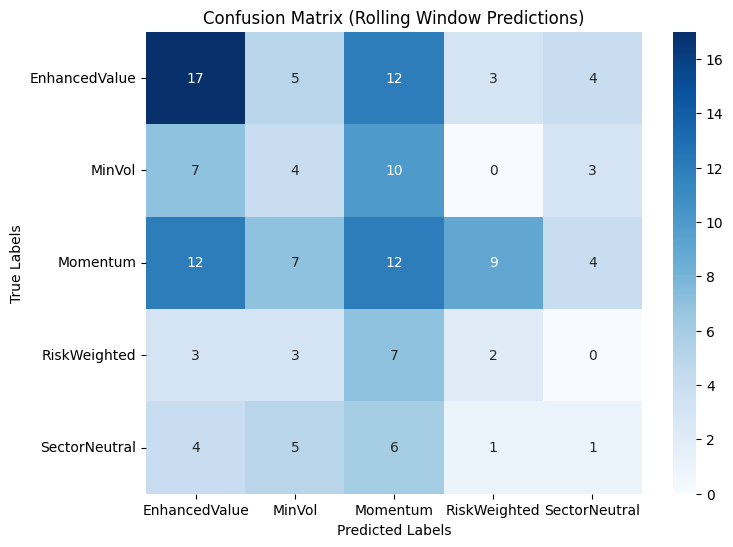

In [275]:
# # Evaluate Accuracy & Confusion Matrix
#
# Compute the overall prediction accuracy and display a confusion matrix heatmap.

# Use REGIMES_COLUMN for consistency if needed; here, we build labels based on winning factors.
labels = [winning_factor_dict[winning_factor_mapping[i]]['short'] for i in sorted(winning_factor_mapping.keys())]
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Rolling Window Predictions)")
plt.show()


No results for regime: High
No results for regime: Normal


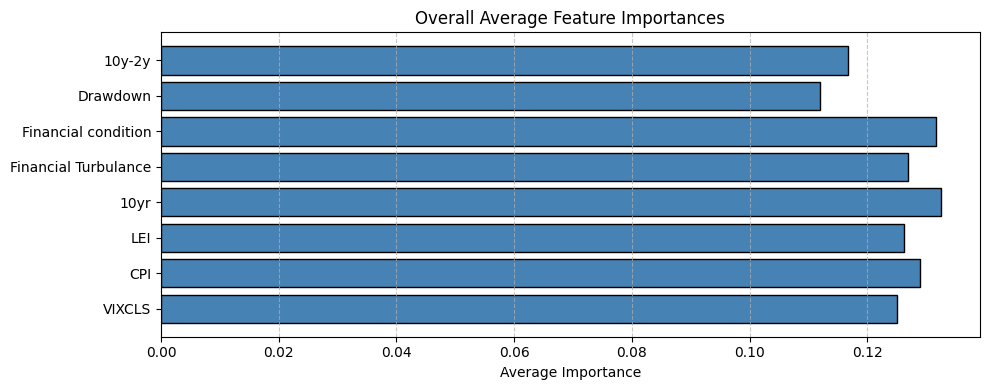

In [276]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1. Overall Feature Importances
# ===============================
# Stack all feature importance arrays into a 2D NumPy array.
overall_fi_array = np.vstack(results_df['Feature_Importances'].values)
overall_avg_fi = overall_fi_array.mean(axis=0)

# ========================================
# 2. Regime-Specific Feature Importances
# ========================================
# Instead of iterating over regime names (strings), we iterate over numeric codes
# and use regime_mapping to convert them back to strings for plotting.
regime_avg_fi = {}
for numeric_code, regime_name in regime_mapping.items():
    # Filter results_df for the current numeric regime code.
    regime_df = results_df[results_df['Regime'] == numeric_code]
    if regime_df.empty:
        print(f"No results for regime: {regime_name}")
        continue  # Skip if there are no results for this regime.
    # Stack and average the feature importances for this regime.
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ===============================
# 3. Plotting the Results
# ===============================
# We'll create one subplot for the overall importances and one for each regime.
# Total subplots = 1 (overall) + number of regimes with available data.
num_regime_plots = len(regime_avg_fi)
total_plots = 1 + num_regime_plots

fig, axs = plt.subplots(total_plots, 1, figsize=(10, total_plots * 4))

# If there's only one subplot, ensure axs is a list.
if total_plots == 1:
    axs = [axs]

# --- Overall Feature Importances Plot ---
axs[0].barh(FEATURES, overall_avg_fi, color='steelblue', edgecolor='black')
axs[0].set_title("Overall Average Feature Importances")
axs[0].set_xlabel("Average Importance")
axs[0].grid(axis='x', linestyle='--', alpha=0.7)

# --- Regime-Specific Feature Importances Plots ---
for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
    axs[idx].barh(FEATURES, avg_fi, color='salmon', edgecolor='black')
    axs[idx].set_title(f"Average Feature Importances for {regime_name}")
    axs[idx].set_xlabel("Average Importance")
    axs[idx].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

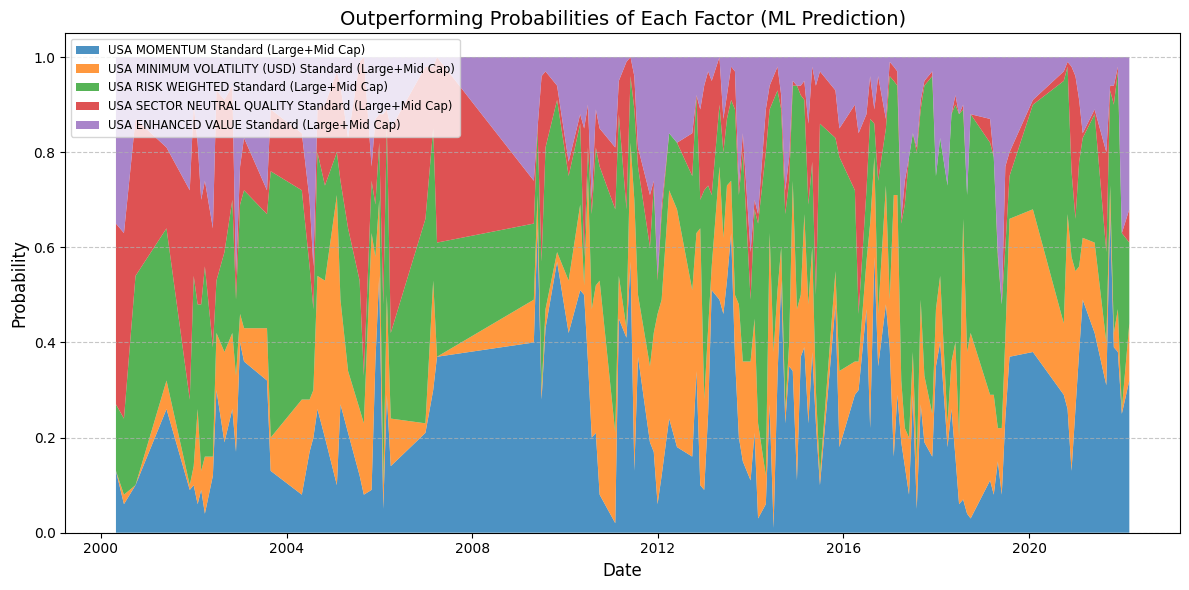

In [277]:
# # Plot Stacked Area Chart of Probabilities
#
# Visualize the evolution of predicted probabilities for each factor over time using a stacked area chart.

# %%
# Build a DataFrame from the probability matrix using the global FACTORS
probability_df = pd.DataFrame(probability_matrix, columns=FACTORS)
probability_df['Date'] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df['Date'],
    [probability_df[col] for col in FACTORS],
    labels=FACTORS,
    alpha=0.8
)
plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(loc='upper left', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Backtesting & statistics

In [288]:
# Print all column names to check for the 'Allocated_Return' column
print("Columns in df:", df.columns.tolist())


Columns in df: ['Date', 'USA Standard (Large+Mid Cap)', 'USA MOMENTUM Standard (Large+Mid Cap)', 'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)', 'USA RISK WEIGHTED Standard (Large+Mid Cap)', 'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)', 'USA ENHANCED VALUE Standard (Large+Mid Cap)', 'Winning Factor', 'VIXCLS', 'GDPC1', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'H.Regimes', 'Financial condition', 'Drawdown', 'HY Spread', 'IG Spread', '10y-2y', 'Vix-regimes2', 'Vix-regimes3', 'Winning Factor Encoded']


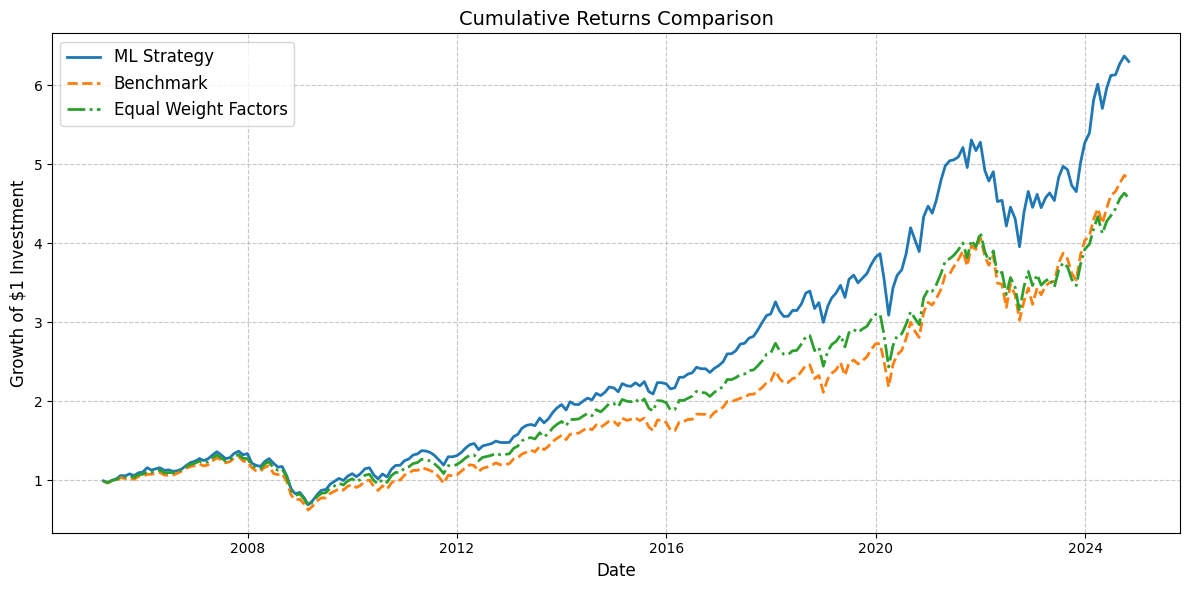

In [312]:
# Extract ML strategy dates and returns
ml_dates = results_df['Predicted_month']
ml_returns = results_df['Allocated_Return']

# Filter the original data to match ML prediction dates (ensure no missing dates for each strategy)
chart_data = df[df['Date'].isin(ml_dates)].copy().sort_values('Date')

# Calculate equal-weighted factor returns (average of all factors)
chart_data['Equal_Weight'] = chart_data[FACTORS].mean(axis=1)

# Add ML returns to the dataframe (ensure alignment)
chart_data['ML_Strategy'] = ml_returns.values

# Calculate cumulative returns
chart_data['ML_Cumulative'] = (1 + chart_data['ML_Strategy']).cumprod()
chart_data['Benchmark_Cumulative'] = (1 + chart_data[BENCHMARK[0]].loc[chart_data.index]).cumprod()
chart_data['Equal_Weight_Cumulative'] = (1 + chart_data['Equal_Weight']).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(chart_data['Date'], chart_data['ML_Cumulative'],
         label='ML Strategy', linewidth=2)
plt.plot(chart_data['Date'], chart_data['Benchmark_Cumulative'],
         label='Benchmark', linestyle='--', linewidth=2)
plt.plot(chart_data['Date'], chart_data['Equal_Weight_Cumulative'],
         label='Equal Weight Factors', linestyle='-.', linewidth=2)

plt.title('Cumulative Returns Comparison', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Growth of $1 Investment', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


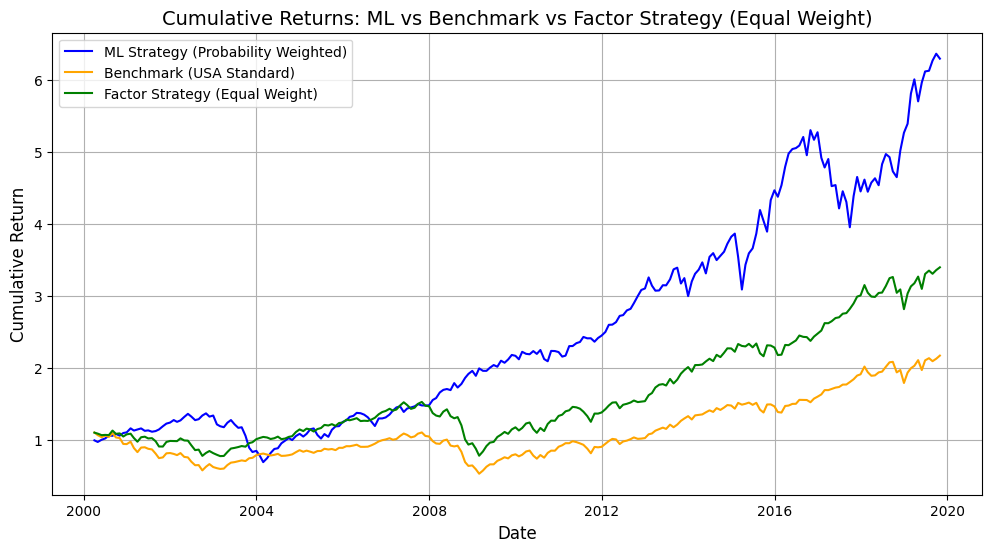

Description,Value
Start Time,2000-03-31
Stop Time,2019-10-31


In [311]:
# Extract ML strategy and benchmark returns (as before)
strategy_returns = np.array(allocated_returns)
benchmark_returns = df.iloc[window_size:]['USA Standard (Large+Mid Cap)'].values[:len(strategy_returns)]

# Compute cumulative returns for ML strategy and benchmark
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Compute the equal-weight factor strategy returns:
# For each date (from window_size onward), take the average of the factor returns.
# Ensure that we use the same number of observations as ML strategy returns.
factor_equal_returns = df.iloc[window_size:][FACTORS].mean(axis=1).values[:len(strategy_returns)]
cumulative_factor_equal = (1 + factor_equal_returns).cumprod()

# Use the common date series from the DataFrame
dates = df.loc[window_size:, 'Date'][:len(cumulative_strategy)]

# Plot all three cumulative return series
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_strategy, label="ML Strategy (Probability Weighted)", color="blue")
plt.plot(dates, cumulative_benchmark, label="Benchmark (USA Standard)", color="orange")
plt.plot(dates, cumulative_factor_equal, label="Factor Strategy (Equal Weight)", color="green")
plt.title("Cumulative Returns: ML vs Benchmark vs Factor Strategy (Equal Weight)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- Extract and Display Start/Stop Times ---

# Ensure dates is a pandas Series; if not, convert it.
if not isinstance(dates, pd.Series):
    dates = pd.Series(dates)

start_time = dates.iloc[0]
stop_time = dates.iloc[-1]

# Create a DataFrame for the start and stop times.
times_df = pd.DataFrame({
    "Description": ["Start Time", "Stop Time"],
    "Value": [start_time, stop_time]
})

# Display the times as a neat HTML table.
display(HTML(times_df.to_html(index=False, classes="table table-striped", border=0)))

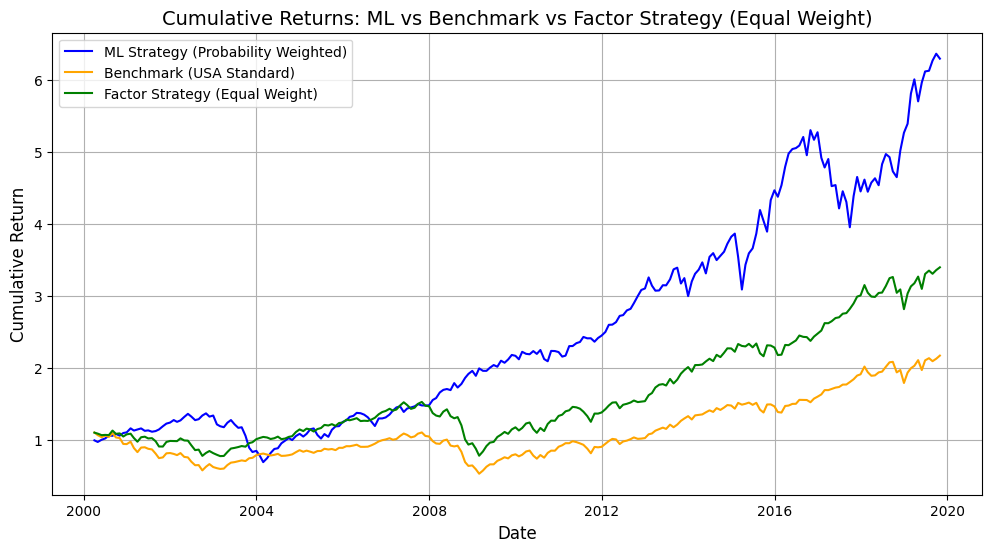

In [307]:
# Extract ML strategy and benchmark returns (as before)
strategy_returns = np.array(allocated_returns)
benchmark_returns = df.iloc[window_size:]['USA Standard (Large+Mid Cap)'].values[:len(strategy_returns)]

# Compute cumulative returns for ML strategy and benchmark
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Compute the equal-weight factor strategy returns:
# For each date (from window_size onward), take the average of the factor returns.
# Ensure that we use the same number of observations as ML strategy returns.
factor_equal_returns = df.iloc[window_size:][FACTORS].mean(axis=1).values[:len(strategy_returns)]
cumulative_factor_equal = (1 + factor_equal_returns).cumprod()

# Use the common date series from the DataFrame
dates = df.loc[window_size:, 'Date'][:len(cumulative_strategy)]

# Plot all three cumulative return series
plt.figure(figsize=(12, 6))
plt.plot(dates, cumulative_strategy, label="ML Strategy (Probability Weighted)", color="blue")
plt.plot(dates, cumulative_benchmark, label="Benchmark (USA Standard)", color="orange")
plt.plot(dates, cumulative_factor_equal, label="Factor Strategy (Equal Weight)", color="green")
plt.title("Cumulative Returns: ML vs Benchmark vs Factor Strategy (Equal Weight)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

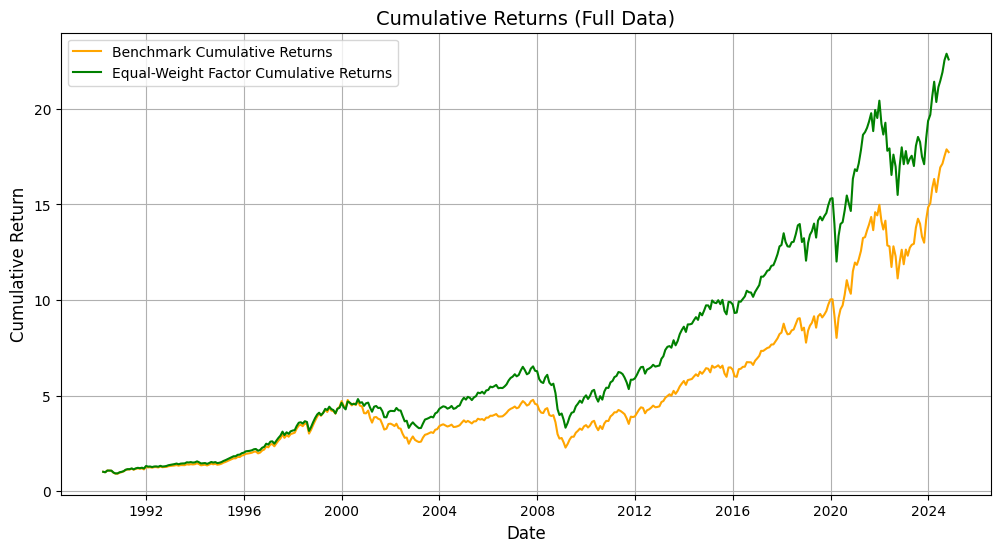

In [292]:
# --- Plotting the cumulative returns chart ---
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

# Extract full-time returns for the benchmark.
benchmark_returns_all = df['USA Standard (Large+Mid Cap)']
cumulative_benchmark_all = (1 + benchmark_returns_all).cumprod()

# Calculate equal-weight factor returns by averaging across all FACTORS columns.
factor_equal_returns_all = df[FACTORS].mean(axis=1)
cumulative_factor_equal_all = (1 + factor_equal_returns_all).cumprod()

# Plot cumulative returns.
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], cumulative_benchmark_all, label="Benchmark Cumulative Returns", color="orange")
plt.plot(df['Date'], cumulative_factor_equal_all, label="Equal-Weight Factor Cumulative Returns", color="green")
plt.title("Cumulative Returns (Full Data)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- Calculate and print annualized returns ---
# Determine the number of periods (months) in the full data.
n_benchmark = len(benchmark_returns_all)
n_factor = len(factor_equal_returns_all)

# Calculate annualized returns using the cumulative returns formula.
annualized_return_benchmark = cumulative_benchmark_all.iloc[-1]**(12 / n_benchmark) - 1
annualized_return_factor = cumulative_factor_equal_all.iloc[-1]**(12 / n_factor) - 1

# Display the annualized returns in a neat HTML block.
display(HTML(
    f"<br>"
    f"<div style='font-size:24px; text-align:center; margin:20px 0;'>"
    f"Annualized Return (Benchmark): {annualized_return_benchmark:.2%}<br>"
    f"Annualized Return (Equal-Weight Factor Strategy): {annualized_return_factor:.2%}"
    f"</div>"
    f"<br>"
))


In [280]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# --- Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def annualized_volatility(returns):
    """Annualize the standard deviation of monthly returns."""
    return np.std(returns) * np.sqrt(12)

def sharpe_ratio(returns):
    """Compute the Sharpe Ratio (assuming zero risk-free rate)."""
    return annualized_return(returns) / annualized_volatility(returns)

def tracking_error(strategy_returns, benchmark_returns):
    """Annualize the standard deviation of the return differences."""
    return np.std(strategy_returns - benchmark_returns) * np.sqrt(12)

def information_ratio(strategy_returns, benchmark_returns):
    """Compute the Information Ratio."""
    excess_return = annualized_return(strategy_returns) - annualized_return(benchmark_returns)
    return excess_return / tracking_error(strategy_returns, benchmark_returns)

# --- Combined Function to Compute & Display Out-of-Sample Metrics ---
def display_out_of_sample_metrics(strategy_returns, benchmark_returns):
    """
    Compute performance metrics for the ML strategy and benchmark returns,
    add start/stop times, and display the results as an HTML table.

    Parameters:
      strategy_returns: pd.Series or array-like, representing ML strategy out-of-sample returns.
      benchmark_returns: pd.Series or array-like, representing benchmark returns.
    """
    # Ensure both arrays have the same length:
    benchmark_returns = benchmark_returns[:len(strategy_returns)]

    # Compute metrics for the ML strategy
    ml_ann_ret    = annualized_return(strategy_returns)
    ml_ann_vol    = annualized_volatility(strategy_returns)
    ml_sharpe     = sharpe_ratio(strategy_returns)
    ml_tracking   = tracking_error(strategy_returns, benchmark_returns)
    ml_info       = information_ratio(strategy_returns, benchmark_returns)

    # Compute metrics for the Benchmark
    bench_ann_ret = annualized_return(benchmark_returns)
    bench_ann_vol = annualized_volatility(benchmark_returns)
    bench_sharpe  = sharpe_ratio(benchmark_returns)

    # Build the metrics DataFrame
    metrics_df = pd.DataFrame({
        "Metric": [
            "Annualized Return",
            "Annualized Volatility",
            "Sharpe Ratio",
            "Tracking Error",
            "Information Ratio"
        ],
        "ML Strategy": [
            f"{ml_ann_ret*100:.2f}%",
            f"{ml_ann_vol*100:.2f}%",
            f"{ml_sharpe:.6f}",
            f"{ml_tracking*100:.2f}%",
            f"{ml_info:.2f}"
        ],
        "Benchmark": [
            f"{bench_ann_ret*100:.2f}%",
            f"{bench_ann_vol*100:.2f}%",
            f"{bench_sharpe:.6f}",
            "nan%",
            "nan"
        ]
    })

    # If strategy_returns has a datetime index, extract start/stop times.
    if hasattr(strategy_returns, 'index'):
        start_time = strategy_returns.index[0]
        stop_time  = strategy_returns.index[-1]
    else:
        start_time = "N/A"
        stop_time  = "N/A"

    # Create extra rows for start and stop times.
    extra_rows = pd.DataFrame({
        "Metric": ["Start Time", "Stop Time"],
        "ML Strategy": [start_time, stop_time],
        "Benchmark": [start_time, stop_time]
    })

    # Combine the metrics and extra rows
    final_df = pd.concat([metrics_df, extra_rows], ignore_index=True)

    # Display as a neat HTML table.
    display(HTML(final_df.to_html(index=False, classes="table table-striped", border=0)))

# --- Example Usage ---
# Here, 'strategy_returns' and 'benchmark_returns' are assumed to be pre-defined (from your rolling window predictions).
# For example, they might be defined as follows:
# strategy_returns = pd.Series(allocated_returns, index=df.loc[window_size:, 'Date'][:len(allocated_returns)])
# benchmark_returns = df.loc[window_size:, 'USA Standard (Large+Mid Cap)'].iloc[:len(strategy_returns)]

# Now display the performance metrics.
display_out_of_sample_metrics(strategy_returns, benchmark_returns)


Metric,ML Strategy,Benchmark
Annualized Return,12.94%,-0.96%
Annualized Volatility,11.02%,16.42%
Sharpe Ratio,1.174934,-0.058419
Tracking Error,19.99%,nan%
Information Ratio,0.70,nan
Start Time,N/A,N/A
Stop Time,N/A,N/A


In [281]:
# # OLS Regression Analysis: Strategy vs Benchmark Returns
#
# Run an OLS regression to examine the relationship between the ML strategy returns and the benchmark returns,
# and display the regression summary.

# %%
regression_data = pd.DataFrame({
    'Strategy': strategy_returns,
    'Benchmark': benchmark_returns
}).dropna()

X_reg = regression_data['Benchmark']
y_reg = regression_data['Strategy']
X_reg = sm.add_constant(X_reg)

model = sm.OLS(y_reg, X_reg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Strategy   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.07869
Date:                Sun, 02 Feb 2025   Prob (F-statistic):              0.780
Time:                        15:45:18   Log-Likelihood:                 286.16
No. Observations:                 141   AIC:                            -568.3
Df Residuals:                     139   BIC:                            -562.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.003      3.967      0.0

# Corr Heat map & regiimi sharpet


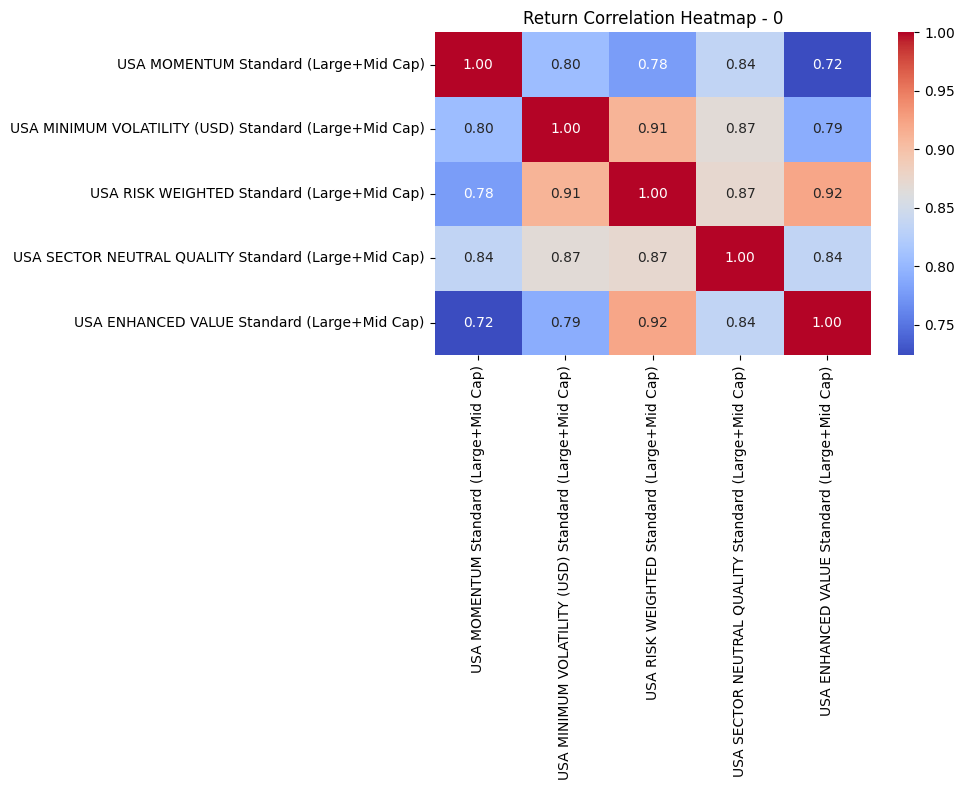

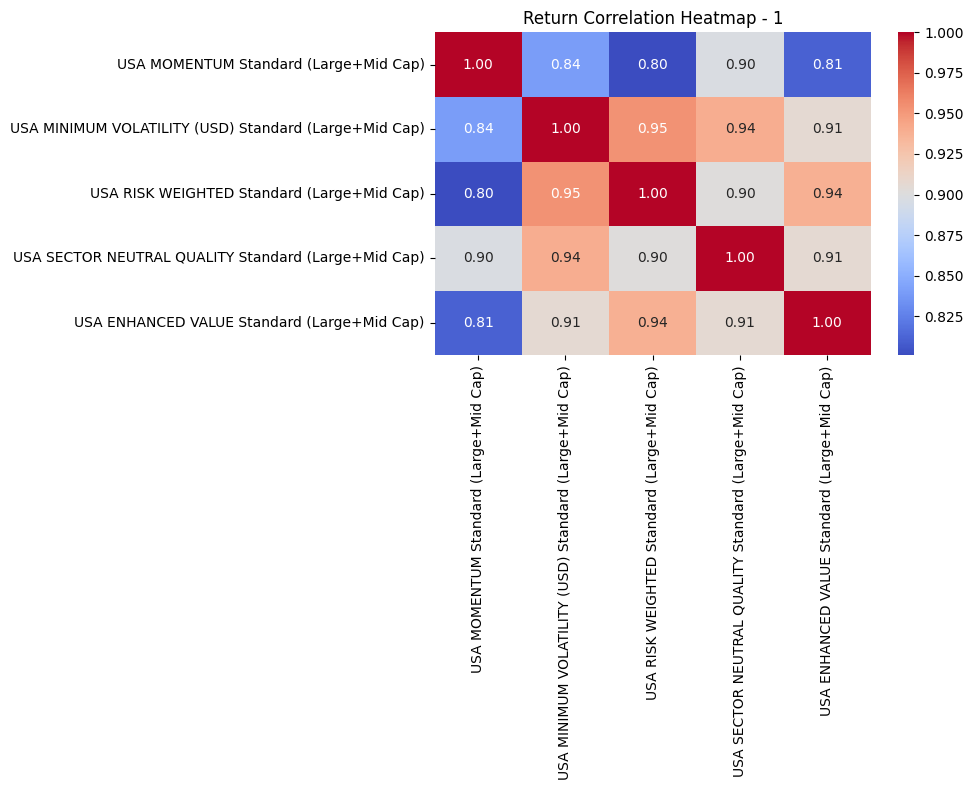

In [282]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



<Figure size 1400x800 with 0 Axes>

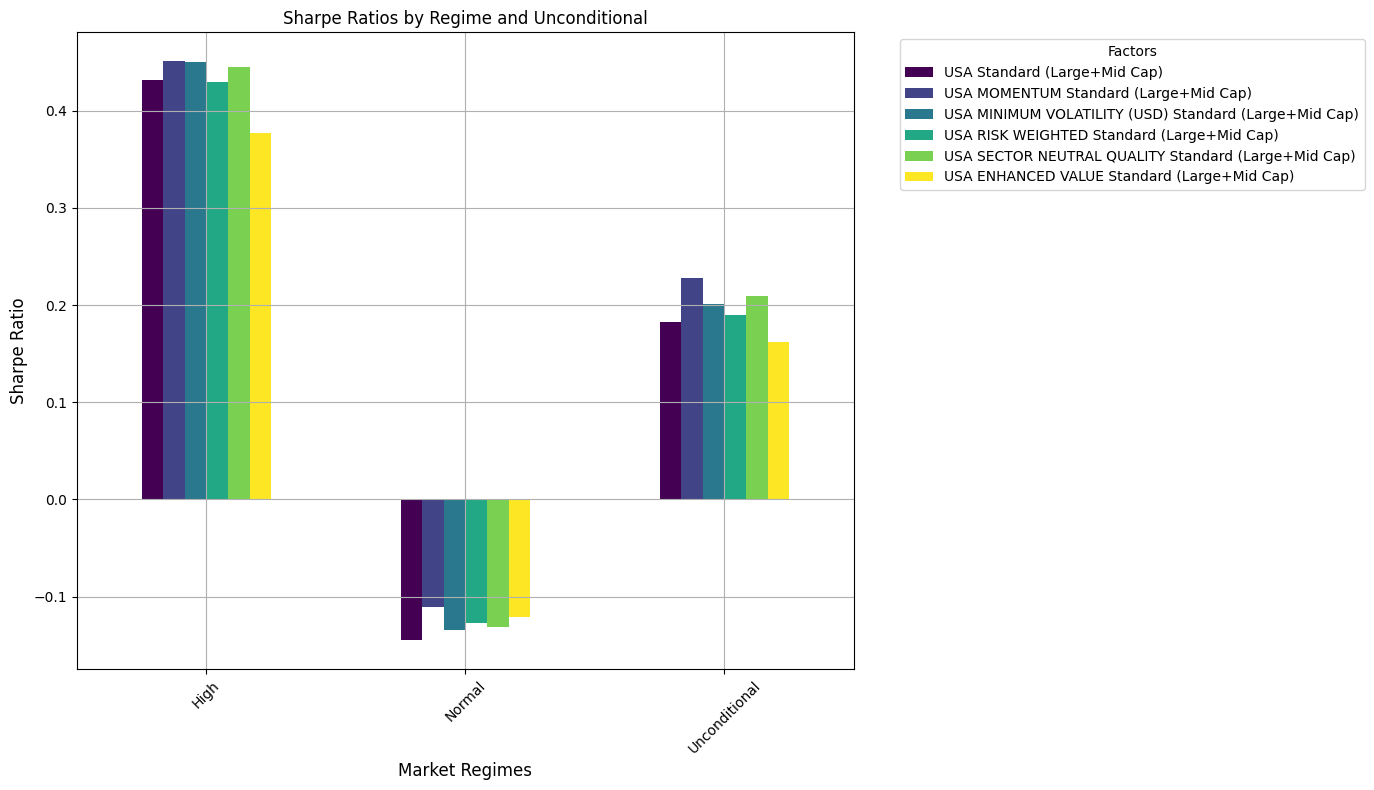

In [283]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = df.columns[1:7]  # Adjust the column indices if needed
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

# Calculate Sharpe ratios by regime using a dictionary comprehension and use the short names as keys.
sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
